In [1]:
!pip install wfdb --quiet
!pip install --upgrade scikit-learn==1.3.2 imbalanced-learn==0.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 80.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Check GPUs
print("Torch version:", torch.__version__)
device_count = torch.cuda.device_count()
print("Available GPUs:", device_count)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use DataParallel for multiple GPUs
def setup_model_for_gpus(model):
    if device_count > 1:
        print(f"Using {device_count} GPUs 🚀")
        model = nn.DataParallel(model)
    return model.to(device)


Torch version: 2.6.0+cu124
Available GPUs: 2



Signal shape: (216000, 2)
Number of annotations: 858
Example labels: ['+', 'L', 'L', 'L', 'L']


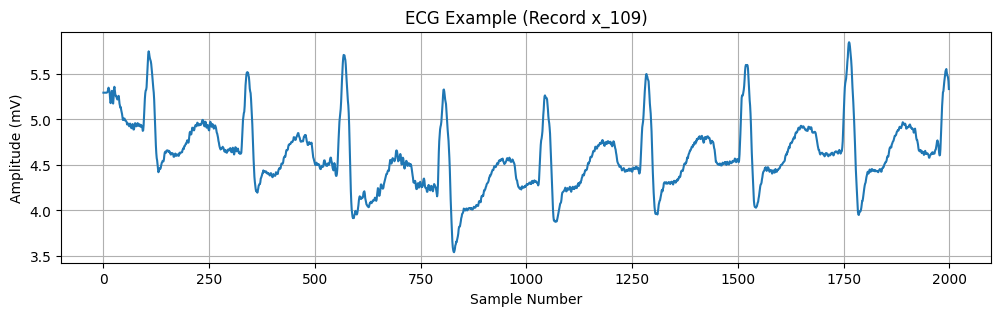

In [3]:
#Load MIT-BIH Dataset
import wfdb
import os
import matplotlib.pyplot as plt 

# This path correctly points to the directory containing the data files.
DATA_PATH = "/kaggle/input/mit-bih-files/mit-bih-arrhythmia-database-1.0.0/x_mitdb"

# Example: Load record '109' which has the filename 'x_109'
record_name = 'x_109'
record = wfdb.rdrecord(os.path.join(DATA_PATH, record_name))
annotation = wfdb.rdann(os.path.join(DATA_PATH, record_name), 'atr')

sig = record.p_signal
r_peaks = annotation.sample
labels = annotation.symbol

print("\nSignal shape:", sig.shape)
print("Number of annotations:", len(r_peaks))
print("Example labels:", labels[:5])

# Plot first 2000 samples
plt.figure(figsize=(12,3))
plt.plot(sig[:2000,0])
plt.title(f"ECG Example (Record {record_name})")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()

In [4]:
from scipy.signal import butter, filtfilt

# Bandpass filter
def bandpass_filter(sig, low=0.5, high=40, fs=360, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, sig)

# Normalize
def normalize(sig):
    return (sig - np.mean(sig)) / np.std(sig)

# Segment beat (window around R-peak)
def segment_beat(signal, r_peak, fs=360, pre=0.3, post=0.4):
    start = int(r_peak - pre*fs)
    end = int(r_peak + post*fs)
    if start < 0 or end > len(signal):
        return None
    return signal[start:end, 0]  # Use first lead

In [5]:
beats = []
beat_labels = []

# --- Loop through all records in the directory ---
for rec_file in os.listdir(DATA_PATH):
    if rec_file.endswith('.dat'):
        # IMPROVED: Use os.path.join for robust file path creation
        rec_name = rec_file.split('.')[0]
        record_path = os.path.join(DATA_PATH, rec_name)
        
        rec = wfdb.rdrecord(record_path)
        ann = wfdb.rdann(record_path, 'atr')
        
        # Preprocess the first ECG lead
        # This creates the cleaned, 1D signal we should use
        sig = normalize(bandpass_filter(rec.p_signal[:,0]))
        
        # --- Iterate through each annotated heartbeat ---
        for i, r_peak in enumerate(ann.sample):
            # We also need to adapt the segment_beat function for a 1D signal.
            
            # Simplified segmentation for a 1D signal
            start = int(r_peak - 0.3 * 360)
            end = int(r_peak + 0.4 * 360)
            
            if start >= 0 and end < len(sig):
                beat = sig[start:end]
                beats.append(beat)
                beat_labels.append(ann.symbol[i])

# --- Map symbols to integers and convert to NumPy arrays ---
label_map = {
    'N': 0,
    'V': 1,
    'A': 2,
    'L': 3,
    'R': 4,
    'F': 5,
    'j': 6,
    'a': 7,
    'J': 8
}

y = [label_map.get(l, 0) for l in beat_labels]
X = np.array(beats)
y = np.array(y)

print("\n--- Processing Complete ---")
print("Total beats extracted:", X.shape[0])
print("Length of each beat segment:", X.shape[1])


--- Processing Complete ---
Total beats extracted: 16520
Length of each beat segment: 252


In [8]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#Calculate the distribution of your training data ---
train_distribution = Counter(y_train)
print(f"Original training distribution: {train_distribution}")

#Find the size of the smallest class ---
min_class_size = min(train_distribution.values())

# Dynamically set k_neighbors ---
# k_neighbors must be an integer and less than the number of samples in the smallest class.
# It also must be at least 1.
k_neighbors_value = max(1, min_class_size - 1)

print(f"\nSmallest class has {min_class_size} samples. Adjusting k_neighbors to {k_neighbors_value}.")

#Apply SMOTE ONLY to the training data ---
print("\nApplying SMOTE to the training data...")
smote = SMOTE(random_state=42,k_neighbors=k_neighbors_value)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# PyTorch Dataset
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (batch, 1, length)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = ECGDataset(X_train_resampled, y_train_resampled)
test_ds = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

# --- Show the new, balanced training set distribution ---
print(f"Resampled training dataset shape: {Counter(y_train_resampled)}")
print(f"Test dataset shape: {Counter(y_test)}")

Original training distribution: Counter({0: 10110, 3: 1231, 4: 804, 1: 607, 2: 414, 8: 24, 5: 18, 6: 5, 7: 3})

Smallest class has 3 samples. Adjusting k_neighbors to 2.

Applying SMOTE to the training data...
Resampled training dataset shape: Counter({0: 10110, 3: 10110, 4: 10110, 1: 10110, 2: 10110, 5: 10110, 8: 10110, 6: 10110, 7: 10110})
Test dataset shape: Counter({0: 2527, 3: 308, 4: 201, 1: 152, 2: 104, 8: 6, 5: 4, 7: 1, 6: 1})


In [9]:
class ECGClassifier(nn.Module):
    def __init__(self, num_classes=15):
        super(ECGClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 16, 7, stride=1, padding=3), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(16, 32, 5, stride=1, padding=2), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 5, stride=1, padding=2), nn.ReLU(), nn.MaxPool1d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (X.shape[1]//8), 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = ECGClassifier(num_classes=len(label_map))
model = setup_model_for_gpus(model)


Using 2 GPUs 🚀


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            out = model(X_batch)
            loss = criterion(out, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_loader):.4f}")
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                out = model(X_batch)
                pred = torch.argmax(out, dim=1)
                correct += (pred == y_batch).sum().item()
                total += y_batch.size(0)
        print(f"Validation Accuracy: {correct/total:.4f}")
    return model

model = train_model(model, train_loader, test_loader, epochs=10)


Epoch 1/10 - Train Loss: 0.0915
Validation Accuracy: 0.9873
Epoch 2/10 - Train Loss: 0.0145
Validation Accuracy: 0.9897
Epoch 3/10 - Train Loss: 0.0112
Validation Accuracy: 0.9927
Epoch 4/10 - Train Loss: 0.0065
Validation Accuracy: 0.9921
Epoch 5/10 - Train Loss: 0.0066
Validation Accuracy: 0.9918
Epoch 6/10 - Train Loss: 0.0054
Validation Accuracy: 0.9927
Epoch 7/10 - Train Loss: 0.0040
Validation Accuracy: 0.9933
Epoch 8/10 - Train Loss: 0.0032
Validation Accuracy: 0.9927
Epoch 9/10 - Train Loss: 0.0025
Validation Accuracy: 0.9942
Epoch 10/10 - Train Loss: 0.0033
Validation Accuracy: 0.9939


In [11]:
# Predictions
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        out = model(X_batch)
        pred = torch.argmax(out, dim=1)
        y_pred.extend(pred.cpu().numpy())
        y_true.extend(y_batch.numpy())

# Classification report
print(classification_report(y_true, y_pred, target_names=label_map.keys()))



              precision    recall  f1-score   support

           N       1.00      1.00      1.00      2527
           V       0.97      0.96      0.97       152
           A       0.94      0.97      0.96       104
           L       1.00      1.00      1.00       308
           R       1.00      1.00      1.00       201
           F       0.50      0.75      0.60         4
           j       1.00      1.00      1.00         1
           a       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         6

    accuracy                           0.99      3304
   macro avg       0.93      0.96      0.95      3304
weighted avg       0.99      0.99      0.99      3304



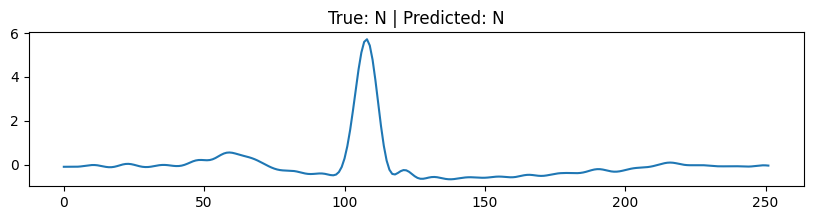

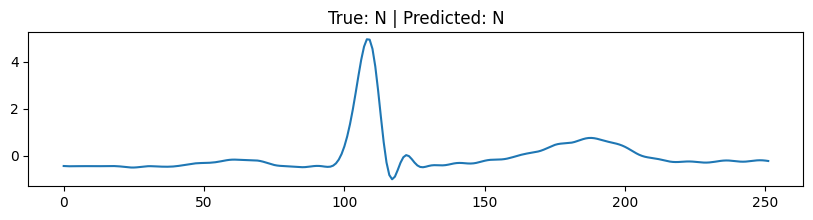

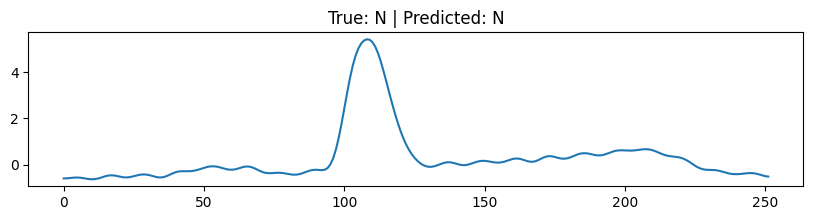

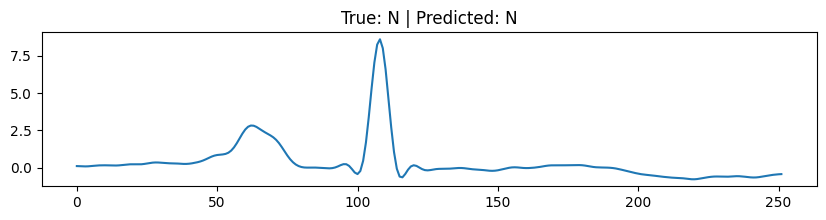

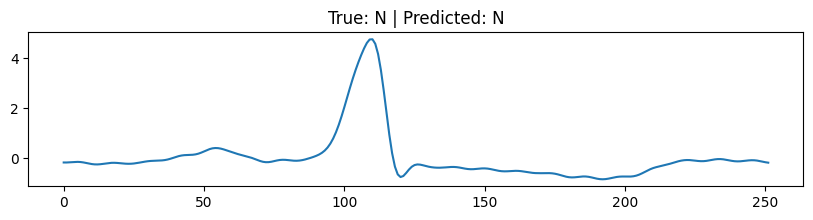

In [12]:
# Assuming your 9-class label_map
label_map = {
    'N': 0,
    'V': 1,
    'A': 2,
    'L': 3,
    'R': 4,
    'F': 5,
    'j': 6,
    'a': 7,
    'J': 8
}

# Reverse mapping: int → class name
label_map_inv = {v: k for k, v in label_map.items()}

import matplotlib.pyplot as plt

# Make sure y_pred is available (predictions on X_test)
for i in range(5):
    plt.figure(figsize=(10,2))
    plt.plot(X_test[i])
    plt.title(f"True: {label_map_inv[y_test[i]]} | Predicted: {label_map_inv[y_pred[i]]}")
    plt.show()


In [13]:
# Define the filename for your weights
WEIGHTS_FILENAME = 'ecg_model_weights.pth'

# Save the model's state dictionary to the file
torch.save(model.state_dict(), WEIGHTS_FILENAME)

print(f"Model weights saved to '{WEIGHTS_FILENAME}'")


Model weights saved to 'ecg_model_weights.pth'
